This demo contains a binary classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data

Create a dataset with 10 000 samples.

In [ ]:
n_samples = 10000

In [ ]:
X, y = make_circles(n_samples = n_samples,
                    noise= 0.05,
                    random_state=26)

In [ ]:
X[:5,:]

array([[ 0.22073819, -0.96356351],
       [ 0.85618516, -0.39409485],
       [ 0.62780991,  0.80606666],
       [ 0.08756986, -0.96283377],
       [ 0.56629646,  0.74976843]])

In [ ]:
y[:5]

array([1, 0, 0, 0, 0])

In [ ]:
circles = pd.DataFrame({"x1": X[:, 0],
                        "x2": X[:, 1],
                        "y": y})

In [ ]:
circles.head()

,x1,x2,y
0,0.220738,-0.963564,1
1,0.856185,-0.394095,0
2,0.627810,0.806067,0
3,0.087570,-0.962834,0
4,0.566296,0.749768,0


Split to train and test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=26)

Visualize the data

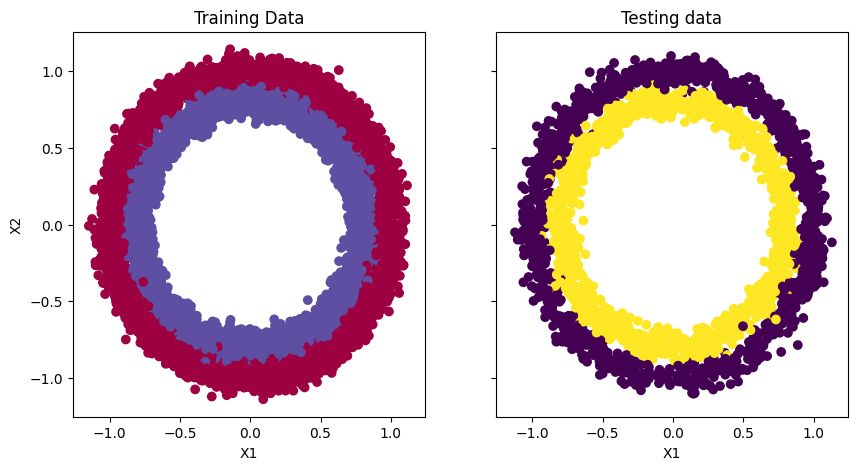

In [ ]:
fig, (train_ax, test_ax) = plt.subplots(ncols=2,
                                        sharex=True,
                                        sharey=True,
                                        figsize=(10, 5))
train_ax.scatter(X_train[:, 0],
                 X_train[:, 1],
                 c=y_train,
                 cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("X1")
train_ax.set_ylabel("X2")

test_ax.scatter(X_test[:, 0],
                X_test[:, 1],
                c=y_test)
test_ax.set_xlabel("X1")
test_ax.set_title("Testing data")
plt.show()

Convert data to tensors

In [ ]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

Move data to GPU if available

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

Create Datasets

In [ ]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

train_dataset = Data(X_train, y_train)
# test_dataset = Data(X_test, y_test)

Create DataLoaders

In [ ]:
batch_size = 64

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
#test_dataloader = DataLoader(dataset=test_dataset,
#                             batch_size=batch_size,
#                             shuffle=True)

Check that dataloader is working

In [ ]:
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


In [ ]:
class ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        # execute the constructor of the superclass (= nn.Module)
        super().__init__()
        # define layers
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_act = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, inputs):
        # forward propagation
        x = self.hidden_act(self.hidden_layer(inputs))
        x = self.output_layer(x)
        return x

In [ ]:
input_dim = 2
hidden_dim = 10
output_dim = 1

Create the model to GPU if available

In [ ]:
model = ANN(input_dim,
            hidden_dim,
            output_dim).to(device)

## Loss function and optimizer

In [ ]:
learning_rate = 0.1

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

In [ ]:
def accuracy_fn(y, y_pred):
    correct = torch.eq(y, y_pred).sum().item() # torch.eq() returns True (1) if tensors are same
    acc = (correct / len(y_pred)) * 100
    return acc

## Training

In [ ]:
torch.manual_seed(42)

In [ ]:
epochs = 100
loss_values = []
accuracys = []
show_intermediate_results = True
interval = epochs / 10

In [ ]:
model.train() # this is default state of model, so this is not necessary

ANN(
  (hidden_layer): Linear(in_features=2, out_features=10, bias=True)
  (hidden_act): ReLU()
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

Training loop

In [ ]:
for epoch in range(epochs):
    batch_loss_values = []
    batch_acc_values = []
    # one batch at a time
    for batch_X, batch_y in train_dataloader:
        # 1. Forward pass
        logits = model(batch_X).squeeze()  # squeeze removes one dimension
        # logits -> pred probabilities -> pred labels
        preds = torch.round(torch.sigmoid(logits))

        # 2. Loss computation
        loss = loss_fn(logits, batch_y)
        batch_loss_values.append(loss.item() * batch_X.size(0))  # loss.item() gives the average loss of batches samples
        acc = accuracy_fn(y=batch_y, y_pred=preds)
        batch_acc_values.append(acc)

        # 3. Initialize gradients
        optimizer.zero_grad()

        # 4. Backward pass
        loss.backward()

        # 5. Weight update
        optimizer.step()

    loss_values.append(np.array(batch_loss_values).sum()/len(train_dataloader.dataset))
    accuracys.append(np.array(batch_acc_values).mean())

    if show_intermediate_results:
        if epoch % interval == 0:
            print(f'Epoch {epoch+1}: loss = {loss_values[-1].round(5)}, accuracy = {accuracys[-1].round(3)} ')
print('Training complete')

Epoch 1: loss = 0.68984, accuracy = 55.005 
Epoch 11: loss = 0.53451, accuracy = 88.678 
Epoch 21: loss = 0.25045, accuracy = 96.703 
Epoch 31: loss = 0.14695, accuracy = 96.954 
Epoch 41: loss = 0.11292, accuracy = 97.1 
Epoch 51: loss = 0.0972, accuracy = 97.016 
Epoch 61: loss = 0.08796, accuracy = 97.233 
Epoch 71: loss = 0.08253, accuracy = 97.219 
Epoch 81: loss = 0.07855, accuracy = 97.352 
Epoch 91: loss = 0.07711, accuracy = 97.272 
Training complete


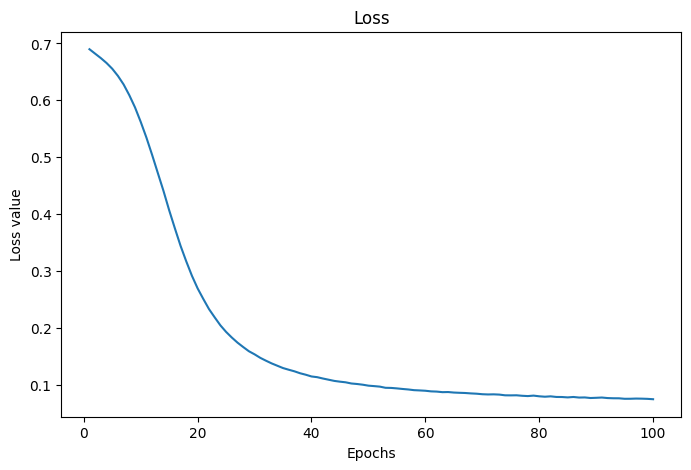

In [ ]:
step = np.arange(1, epochs+1)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

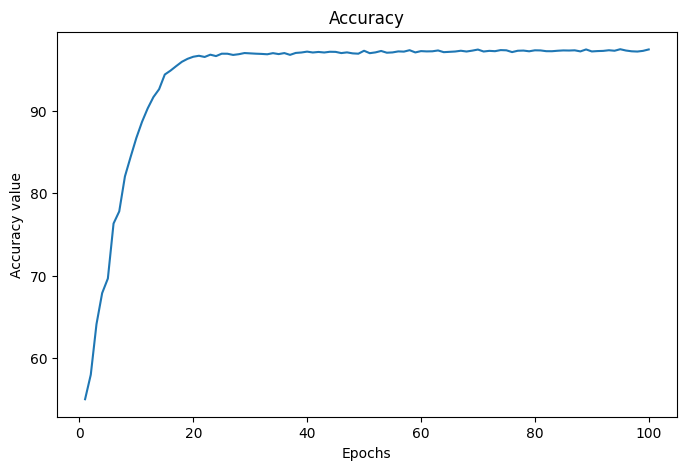

In [ ]:
step = np.arange(1, epochs+1)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(accuracys))
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy value")
plt.show()

## Evaluating

In [ ]:
# set model to the testing mode
model.eval()

ANN(
  (hidden_layer): Linear(in_features=2, out_features=10, bias=True)
  (hidden_act): ReLU()
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
with torch.inference_mode():
    logits = model(X_test).squeeze()
    # logits -> pred probabilities -> pred labels
    preds = torch.round(torch.sigmoid(logits))
    test_loss = loss_fn(logits, y_test)
    test_acc = accuracy_fn(y=y_test, y_pred=preds)

print(f'Test data: loss = {test_loss.cpu().numpy()}, accuracy = {round(test_acc,3)}')

Test data: loss = 0.06642480194568634, accuracy = 98.2


In [ ]:
# set model back to training mode
model.train()

ANN(
  (hidden_layer): Linear(in_features=2, out_features=10, bias=True)
  (hidden_act): ReLU()
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)